In [104]:
%matplotlib inline

import os
import sys
import time
import ctypes
import multiprocessing
import warnings

import dicom
import csv
import pickle
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf

from copy import deepcopy
from collections import namedtuple
from scipy.misc import imread
from scipy import stats
from scipy import ndimage
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import data
from skimage.measure import label, regionprops, perimeter
from skimage.filters import roberts, sobel
from skimage.morphology import ball, disk, dilation, binary_erosion
from skimage.morphology import remove_small_objects, erosion, closing
from skimage.morphology import reconstruction, binary_closing
from skimage.morphology import binary_dilation, binary_opening
from skimage.segmentation import clear_border
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import pyplot as plt

In [105]:
# Utility functions

def save(**kwargs):
    with open('save.dat', 'wb') as f:
        pickle.dump(kwargs, f)


def load():
    with open('save.dat', 'rb') as f:
        return pickle.load(f)

## Read Basic Patient Data
* Use '7z x stage1.7z' to uncompress data.

In [106]:
_DATA_DIR = '../ct_data/sample_images'
_LABELS_CSV = '../ct_data/stage1_labels.csv'
_SAMPLE_CSV = '../ct_data/stage1_sample_submission.csv'


def read_patient_labels(csv_fname):
    with open(csv_fname) as f:
        reader = csv.reader(f, delimiter=',')
        reader.next()  # skip header
        return dict([(r[0], float(r[1])) for r in reader if len(r) == 2])

In [107]:
patient_names = os.listdir(_DATA_DIR)
patient_labels = read_patient_labels(_LABELS_CSV)
test_patient_names = set(read_patient_labels(_SAMPLE_CSV).keys())

## Preprocess Data

In [108]:
def load_scans(patient_name):
    path = os.path.join(_DATA_DIR, patient_name)
    slices = [dicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] -
                                 slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation -
                                 slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    outside_idx = (image == -2000)
    
    # Convert to Hounsfield units (HU)
    intercept = float(scans[0].RescaleIntercept)
    slope = float(scans[0].RescaleSlope)
    
    image = (slope * image + intercept).astype(np.int16)
    image[outside_idx] = -1000  # HU of air
    
    return image


def resample(image, scans, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scans[0].SliceThickness] + scans[0].PixelSpacing))
    spacing = np.array(list(spacing))
    
    resize_factor = spacing / new_spacing
    image = ndimage.interpolation.zoom(image, resize_factor)
    
    return image

In [139]:
p1_name = patient_names[2] #'0acbebb8d463b4b9ca88cf38431aac69'
p1_scans = load_scans(p1_name)
p1_image = get_pixels_hu(p1_scans)
p1_image_resampled = resample(p1_image, p1_scans, [1, 1, 1])

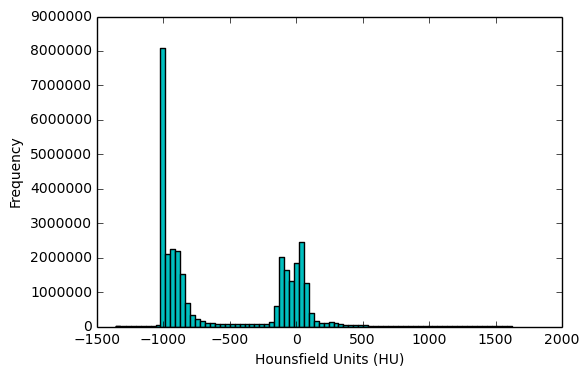

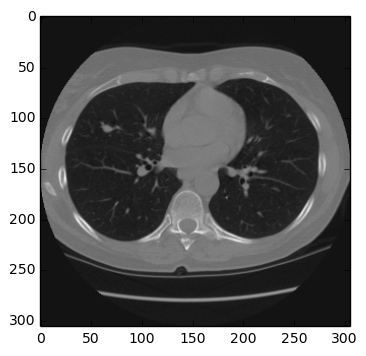

In [110]:
image = p1_image_resampled

# HU histogram
plt.figure()
plt.hist(image.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.figure()
plt.imshow(image[image.shape[0]//2], cmap=plt.cm.gray)
plt.show()

## Plot 3D

In [111]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

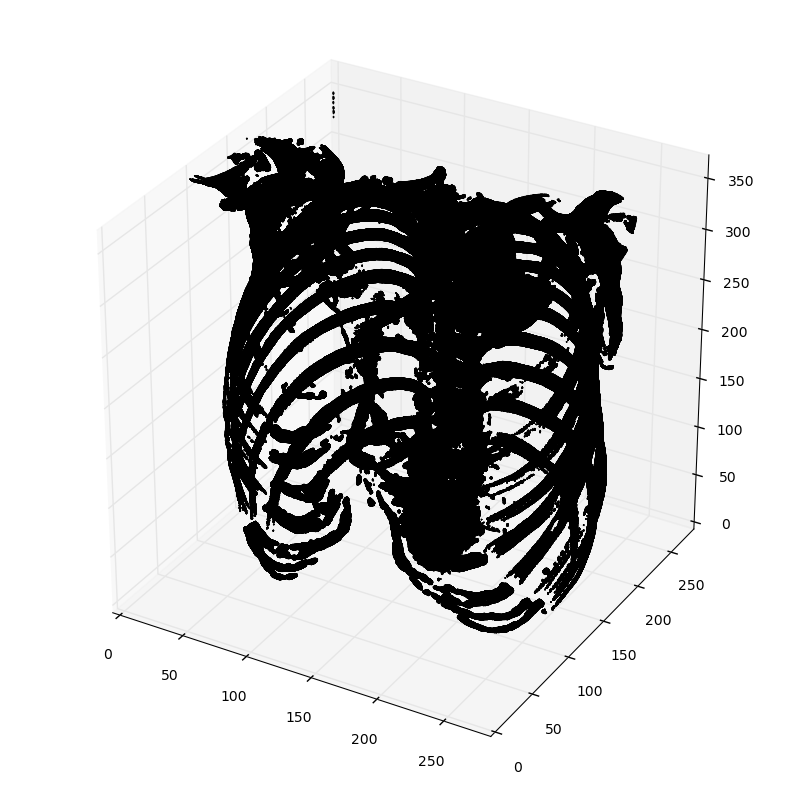

In [30]:
plot_3d(p1_image_resampled, 400)

## Lung Segmentation

In [166]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


def segment_lung_mask(image):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if True:  # fill_lung_structures
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image


def _segment_lung_mask_v2_impl(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -400
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndimage.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
        
    return binary


def segment_lung_mask_v2(image):
    binary = np.stack([
        _segment_lung_mask_v2_impl(im)
        for im in image
    ])

    labels = measure.label(binary)    
    vals, counts = np.unique(labels, return_counts=True)
    counts = counts[vals != 0]
    vals = vals[vals != 0]
    counts_and_vals = sorted(zip(counts, vals), key=lambda x: -x[0])
    
    if len(counts) == 0:
        return None
    
    max_label_counts, max_label = counts_and_vals[0]
    if len(counts) == 1:
        binary[labels!=max_label] = 0
        return binary
    
    max2_label_counts, max2_label = counts_and_vals[1]
    if max2_label_counts > 0.5 * max_label_counts:
        binary[(labels!=max_label)&(labels!=max2_label)] = 0

    return binary

In [167]:
p1_lungs = segment_lung_mask_v2(p1_image_resampled)

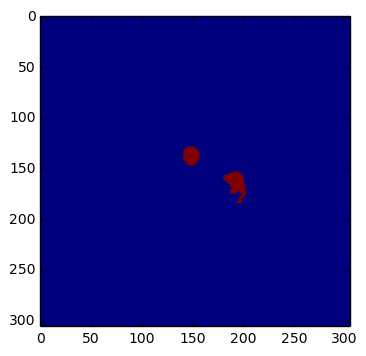

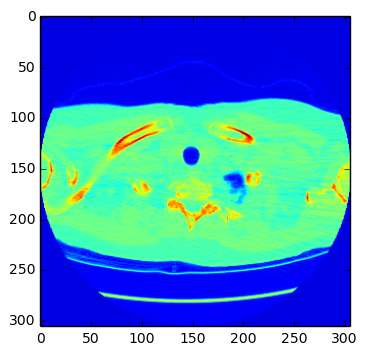

In [172]:
z = 10
plt.figure()
plt.imshow(p1_lungs[z])
plt.figure()
plt.imshow(p1_image_resampled[z])